# HAADF-STEM tomography of Er-doped porous Si
### Example of 2D reconstruction.
### Note: the tilt angle should be horizontal.

## Import Python modules

In [1]:
%matplotlib inline

import os

import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import rotate, radon, iradon, iradon_sart
from skimage.external.tifffile import imsave

from modopt.opt.proximity import SparseThreshold
from modopt.opt.cost import costObj

from Pyetomo import fourier, gradient, linear, reconstruct, reweight, utils

# Import the experimental dataset

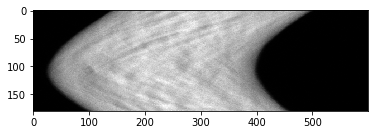

In [5]:
Needle = imread('../Data/Er_doped_SiPor.tif')
Sinogram_2D = Needle[:,624-300:624+300,40]
plt.imshow(Sinogram_2D,cmap='gray')

In [6]:
angular_step= 1. # angular step, in degrees
angular_range_min = 0. # minimum tilt angle, in degrees
angular_range_max = 180. # maximum tilt angle, in degrees (excluded)
theta_full =  np.arange(angular_range_min, angular_range_max, angular_step) # projection angles, in degrees
print(theta_full.shape)

(180,)


# Reconstruction by filtered backprojection (FBP)

In [7]:
fbp = iradon(Sinogram_2D[::1].T, theta=theta_full, circle=True)
fbp_5 = iradon(Sinogram_2D[::5].T, theta=theta_full[::5], circle=True)

Text(0.5, 1.0, 'FBP, tilt increment: 5°')

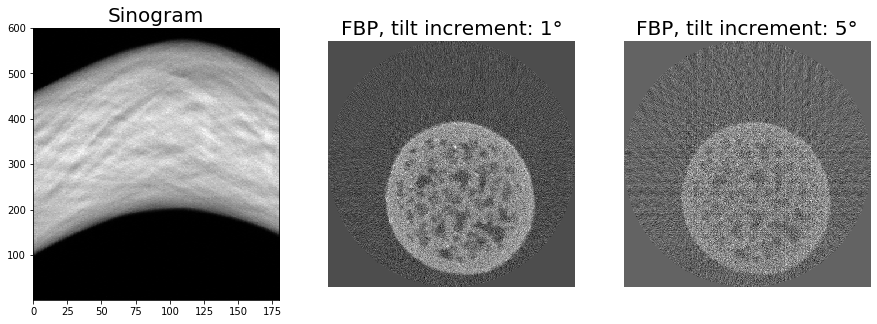

In [8]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize = (15,5))

ax0.imshow(Sinogram_2D.T, cmap=plt.cm.gray, extent=(angular_range_min, angular_range_max, angular_step, Sinogram_2D.T.shape[0]), aspect='auto') 
ax0.axis('on')
ax0.set_title('Sinogram',{'fontsize': 20})

ax1.imshow(fbp,cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('FBP, tilt increment: 1°',{'fontsize': 20})

ax2.imshow(fbp_5,cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title('FBP, tilt increment: 5°',{'fontsize': 20})

In [ ]:
angular_incr=5

theta = theta_full [::angular_incr]
sinogram = Sinogram_2D[::angular_incr]

fbp_reduced = iradon(sinogram.T, theta=theta_full[::angular_incr], circle=True)

# Step 1: Define NUFFT sampling:

kspace_lib = utils.generate_kspace_etomo_2D(sinogram)
samples_lib = np.pi*2*utils.generate_locations_etomo_2D(sinogram.shape[1],theta)
fourier_op = fourier.NUFFT2(samples_lib,[sinogram.shape[1],sinogram.shape[1]])
 
# Step 2: Define the gradient calculation: 

gradient_op = gradient.GradAnalysis(data=kspace_lib, fourier_op=fourier_op)

# Step 3: Define the sparsity operator linear_op, the threshold proximity operation prox_op and the cost function cost_op:


# Bior4.4 undecimated:
linear_op_bior4_undecimated = linear.pyWavelet('bior4.4', nb_scale = 2, undecimated = True)
prox_op_bior4_undecimated = SparseThreshold(linear_op_bior4_undecimated, 1, thresh_type="soft")
cost_op_bior4_undecimated = costObj((gradient_op,prox_op_bior4_undecimated), verbose=False)

# Bior4.4 decimated:
linear_op_bior4_decimated = linear.pyWavelet('bior4.4', nb_scale = 2, undecimated = False)
prox_op_bior4_decimated = SparseThreshold(linear_op_bior4_decimated, 1, thresh_type="soft")
cost_op_bior4_decimated = costObj((gradient_op,prox_op_bior4_decimated), verbose=False)

# Haar:
linear_op_haar = linear.pyWavelet('haar', nb_scale=3)
prox_op_haar = SparseThreshold(linear_op_haar, 1, thresh_type="soft")
cost_op_haar = costObj((gradient_op,prox_op_haar), verbose=False)

#TV:
linear_op_tv = linear.HOTV([sinogram.shape[1],sinogram.shape[1]], order=1)
prox_op_tv = SparseThreshold(linear_op_tv, 1, thresh_type="soft")
cost_op_tv = costObj((gradient_op,prox_op_tv), verbose=False)

#HOTV, order = 3:
linear_op_hotv3 = linear.HOTV([sinogram.shape[1],sinogram.shape[1]], order=3)
prox_op_hotv3 = SparseThreshold(linear_op_hotv3, 1, thresh_type="soft")
cost_op_hotv3 = costObj((gradient_op,prox_op_hotv3), verbose=False)


# Step 4: Run the Condat-Vu sparse reconstruction:

rec_ = []

regul_param = [4, 4, 10, 10, 10]
sparse_op = ['TV', 'HOTV_3', 'Haar', 'Bior4.4_Undecimated', 'Bior4.4_Decimated']
linear_op = [linear_op_tv, linear_op_hotv3, linear_op_haar, linear_op_bior4_undecimated, linear_op_bior4_decimated]
prox_op = [prox_op_tv, prox_op_hotv3, prox_op_haar, prox_op_bior4_undecimated, prox_op_bior4_decimated]
cost_op = [cost_op_tv, cost_op_hotv3, cost_op_haar, cost_op_bior4_undecimated, cost_op_bior4_decimated]

"""
# For selecting the regularization parameter:

mu=[100,200,300,400,500]

for k,m in enumerate(mu):
    reconstruction, wt_coeff, costs, metrics = reconstruct.sparse_rec_condatvu(
        gradient_op,
        linear_op[0],
        prox_op[0],
        cost_op[0],
        mu=m,
        max_nb_of_iter=300,
        nb_of_reweights=2,
        add_positivity=True,
        verbose=0)
    rec_.append(np.abs(reconstruction))
""" 


for k,m in enumerate(sparse_op):
    reconstruction, wt_coeff, costs, metrics = reconstruct.sparse_rec_condatvu(
        gradient_op,
        linear_op[k],
        prox_op[k],
        cost_op[k],
        mu=regul_param[k],
        max_nb_of_iter=300,
        nb_of_reweights=1,
        add_positivity=True,
        verbose=0)
    rec_.append(np.abs(reconstruction))
    
## For saving the 2D reconstructions: 
#for k,m in enumerate(sparse_op):
#    imsave('2D_HAADF_Rec_' + str(sparse_op[k]) + '_mu_'+ str(regul_param[k])+ '.tif', np.asarray(np.abs(rec_[k])).astype('float32')) 

100% (300 of 300) |######################| Elapsed Time: 0:02:11 Time:  0:02:11
 80% (242 of 300) |#################     | Elapsed Time: 0:02:19 ETA:   0:00:33

In [ ]:
sinogram.shape[1]

In [ ]:
# Plot of the reconstructions:

fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(2, 3, figsize = (15,10))

ax0.imshow(rec_[0],cmap=plt.cm.gray)
ax0.axis('off')
ax0.set_title(str(sparse_op[0]),{'fontsize': 20})

ax1.imshow(rec_[1],cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title(str(sparse_op[1]),{'fontsize': 20})

ax2.imshow(rec_[2],cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title(str(sparse_op[2]),{'fontsize': 20})

ax3.imshow(rec_[3],cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title(str(sparse_op[3]),{'fontsize': 20})

ax4.imshow(rec_[4],cmap=plt.cm.gray)
ax4.axis('off')
ax4.set_title(str(sparse_op[4]),{'fontsize': 20})

ax5.imshow(rotate(fbp_reduced, -90),cmap=plt.cm.gray)
ax5.axis('off')
ax5.set_title('FBP',{'fontsize': 20})